In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple

import corner


In [2]:
from starccato_flow.data.toy_data import ToyData
from starccato_flow.data.ccsn_data import CCSNData
from starccato_flow.data.ccsn_snr_data import CCSNSNRData
from starccato_flow.training.trainer import Trainer

from starccato_flow.plotting.plotting import plot_reconstruction_distribution

MPS device found


/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from starccato_flow.utils.defaults import DEVICE

### Dataset Plots

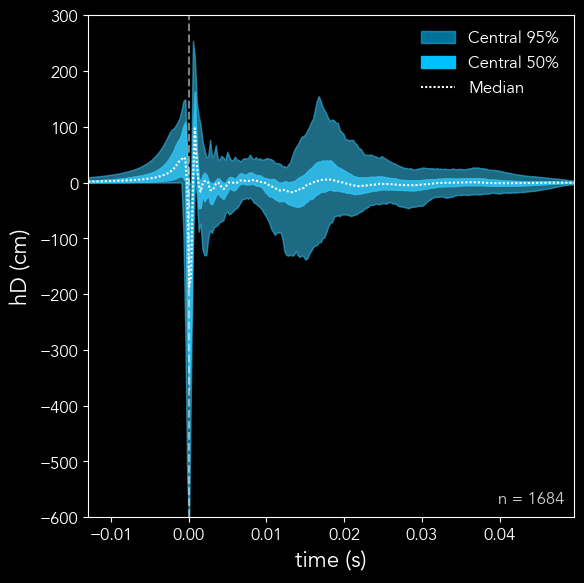

In [4]:
ccsn_dataset = CCSNSNRData(noise=True, curriculum=False)
ccsn_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir", fname="plots/ccsn_signal_distribution.svg")

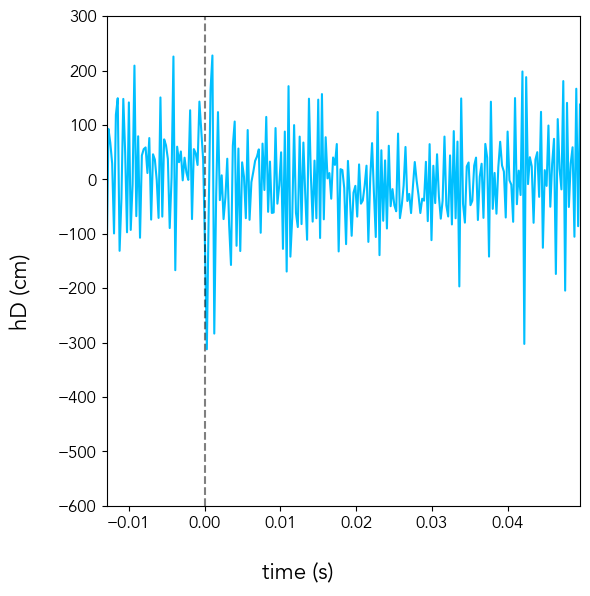

In [5]:
ccsn_dataset.update_snr(8)
ccsn_dataset.plot_signal_grid(background="white", font_family="sans-serif", font_name="Avenir", fname="plots/ccsn_signal_grid.svg")

In [6]:
toy=False

### Train VAE + Flow


=== Data Split (on base signals) ===
Total base signals: 1684
Training base signals: 1516
Validation base signals: 168
First 5 training indices: [ 360  336   81  684 1374]
First 5 validation indices: [722 519 222  32 111]
✓ Verification PASSED: No overlap between train and validation sets
  Train signals: 1516 unique indices
  Val signals: 168 unique indices
  Total coverage: 1684 / 1684

Verifying data alignment:
Number of signals: 1516
Number of parameter sets: 1516
Parameter columns: ['beta1_IC_b', 'A(km)', 'Ye_c_b', 'omega_0(rad|s)']
First few parameter values:
      beta1_IC_b  A(km)   Ye_c_b  omega_0(rad|s)
369     0.144352    467  0.26472             8.5
345     0.121586    300  0.26472            10.0
84      0.172129    300  0.27792            12.5
708     0.001442    300  0.28282             1.0
1447    0.047885    634  0.28170             4.0

Verifying data alignment:
Number of signals: 168
Number of parameter sets: 168
Parameter columns: ['beta1_IC_b', 'A(km)', 'Ye_c_b', 

Epochs:   6%|▌         | 15/256 [00:38<09:42,  2.42s/it]

Generated signals shape: (32, 256)


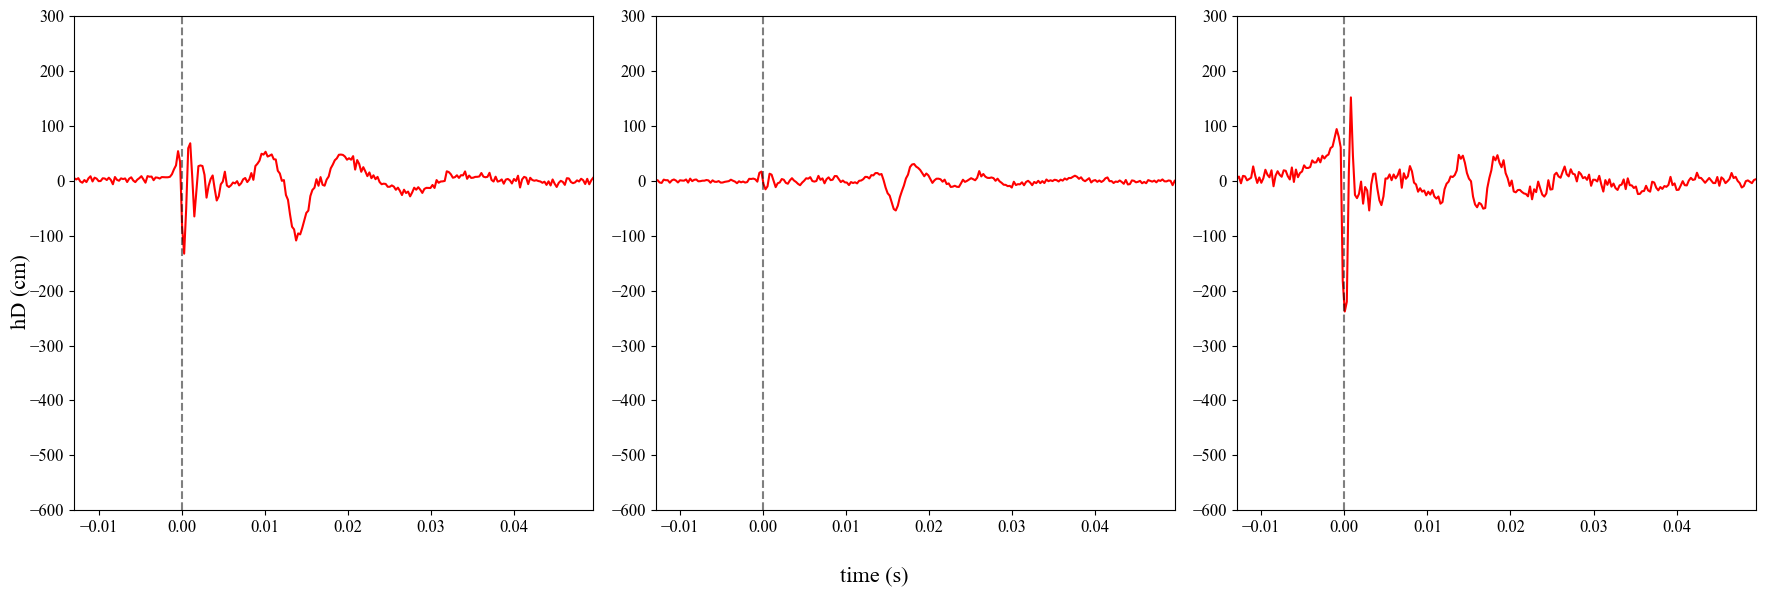

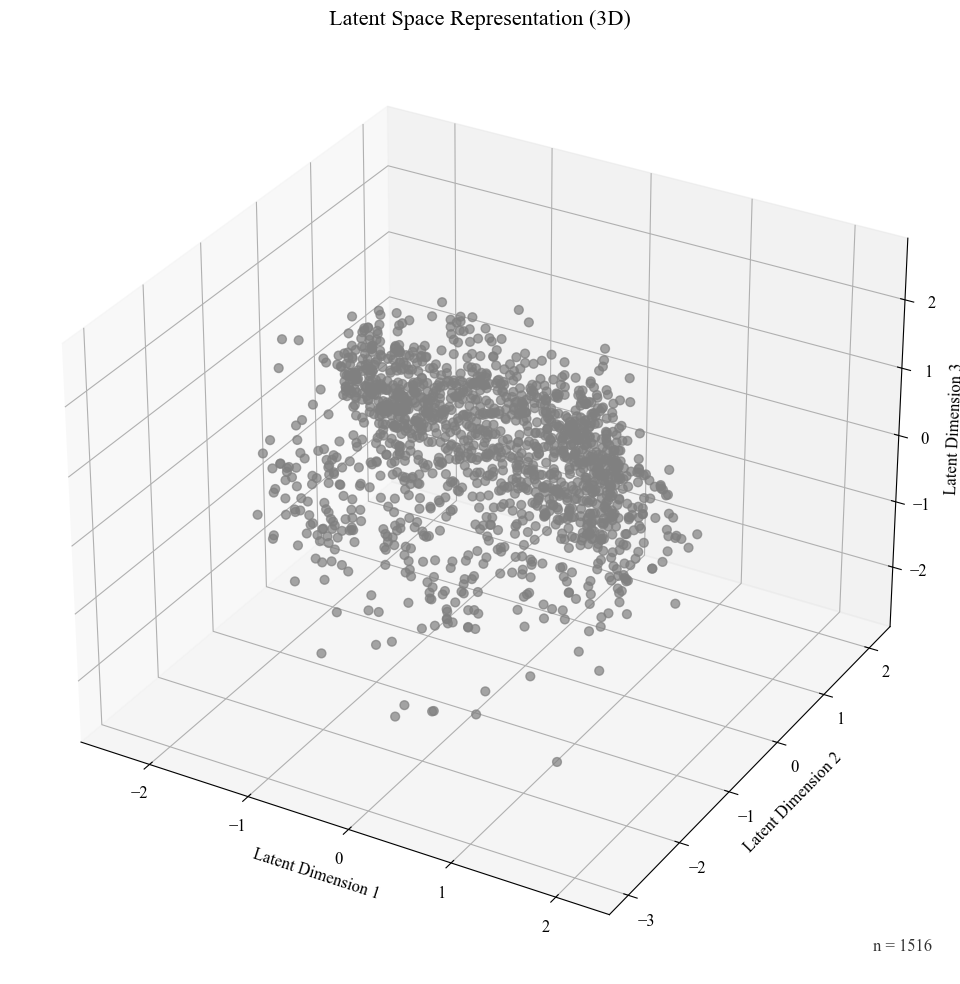

Epochs:  12%|█▏        | 31/256 [01:18<08:19,  2.22s/it]

Generated signals shape: (32, 256)


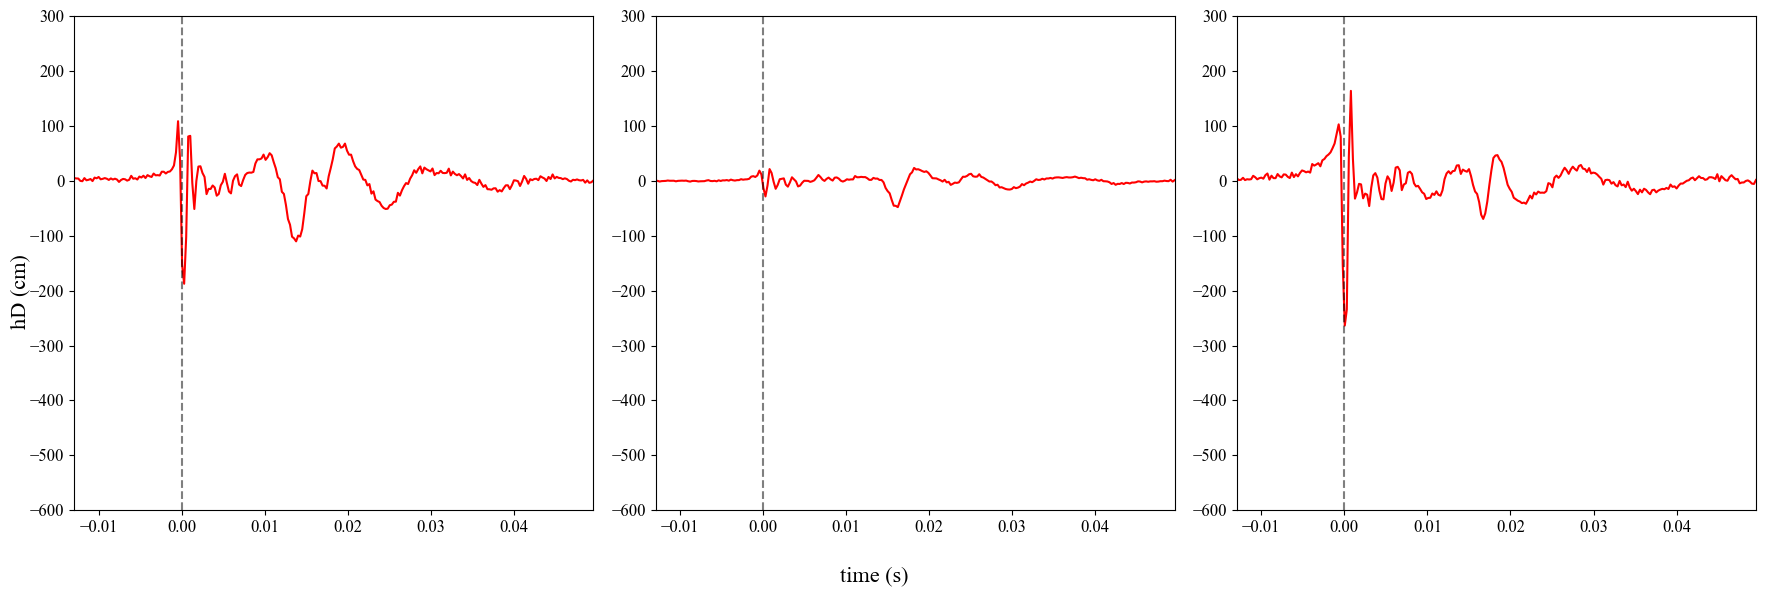

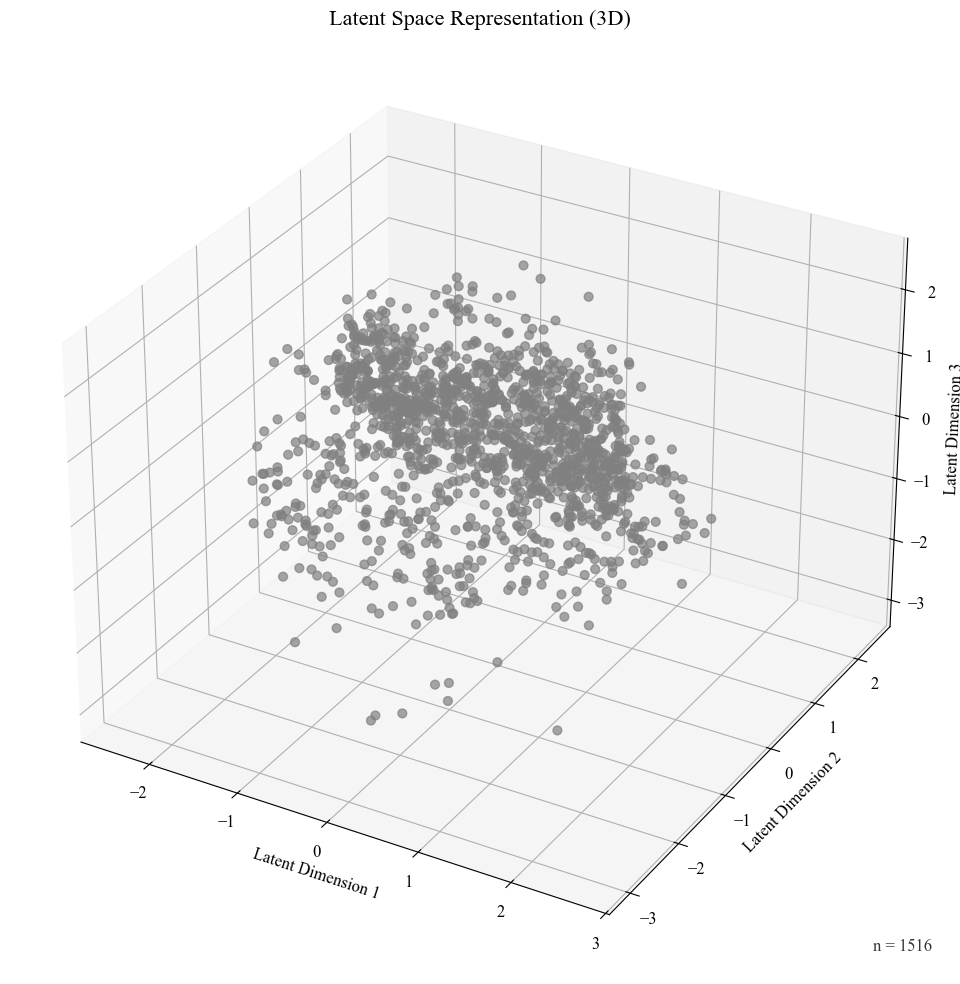

Epochs:  18%|█▊        | 47/256 [01:57<08:19,  2.39s/it]

Generated signals shape: (32, 256)


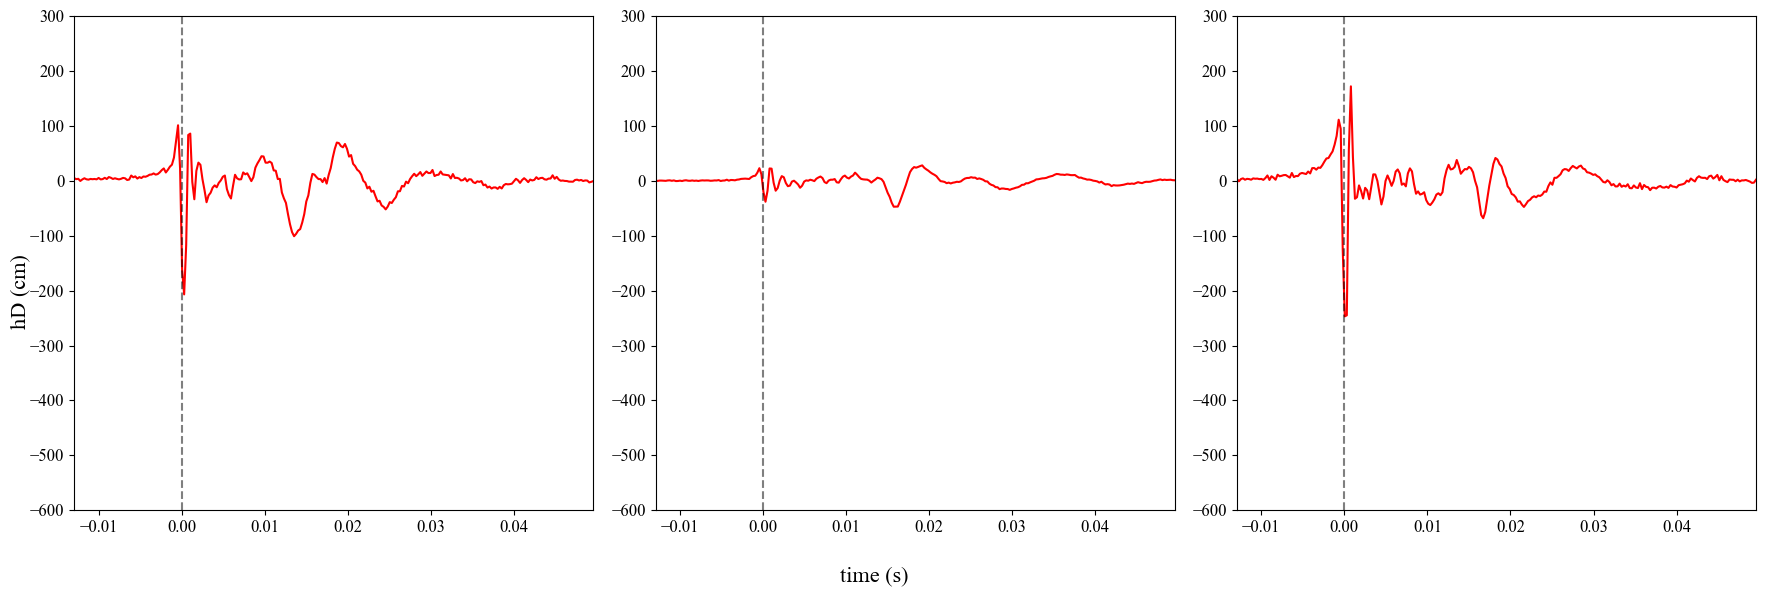

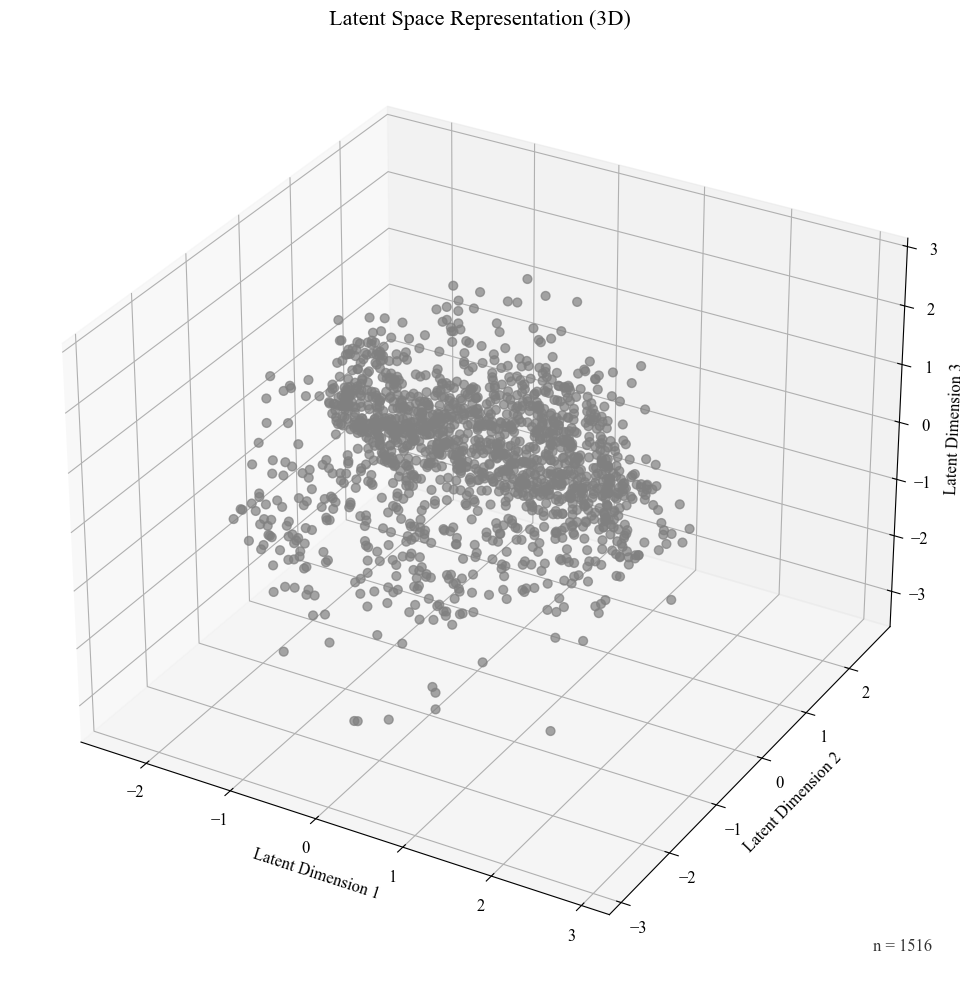

Epochs:  25%|██▍       | 63/256 [02:35<07:15,  2.26s/it]

Generated signals shape: (32, 256)


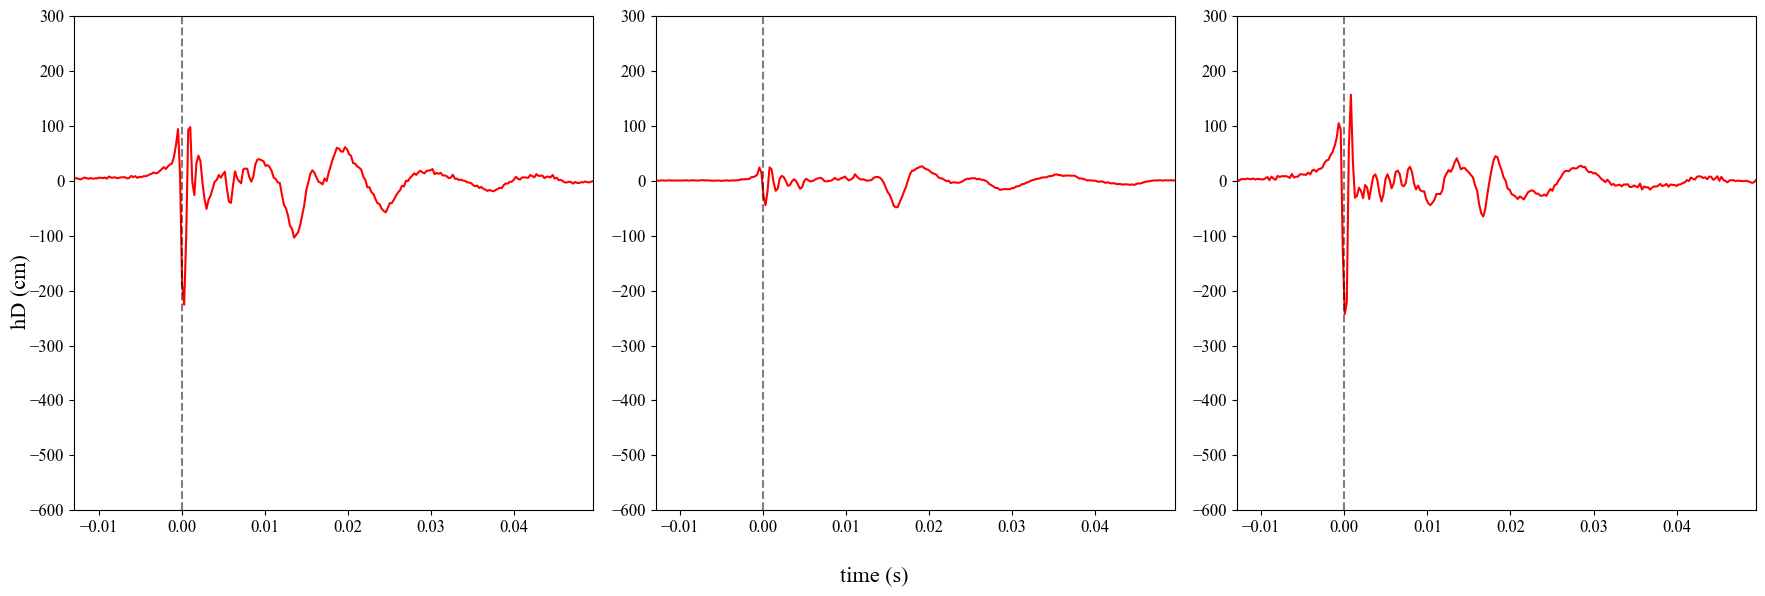

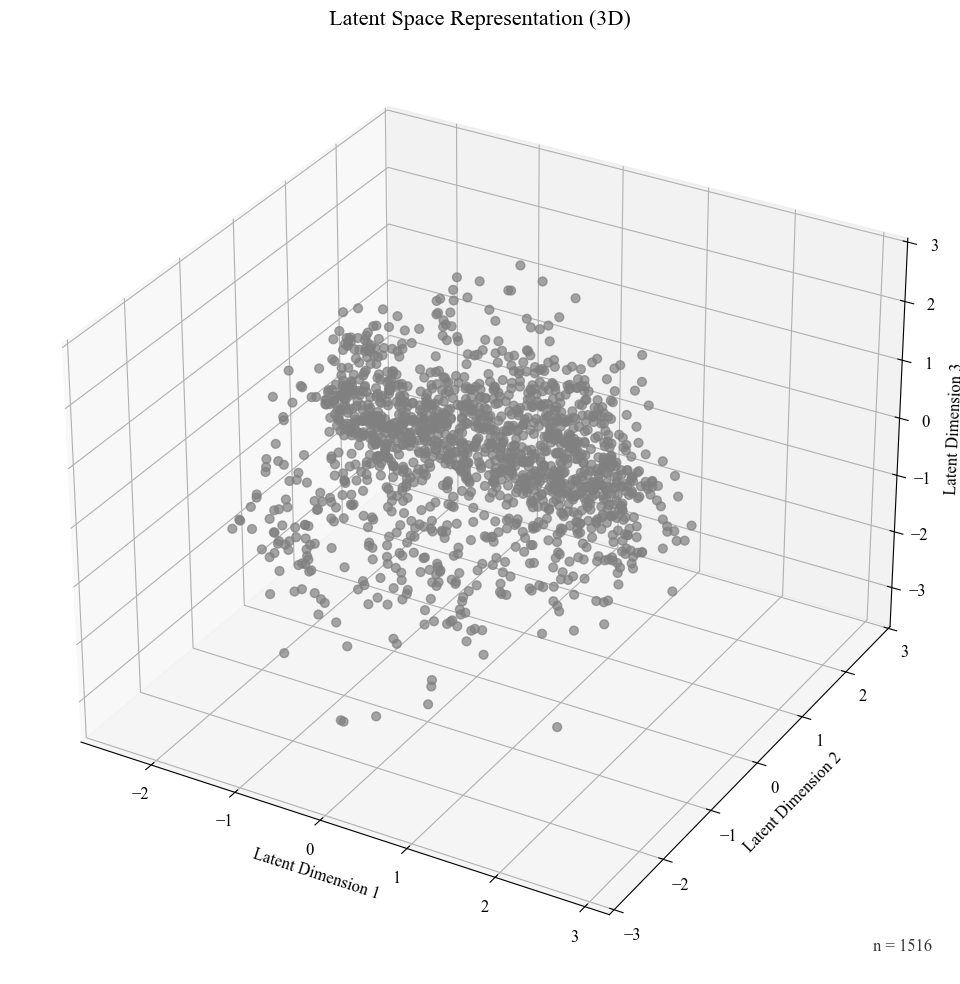

Epochs:  31%|███       | 79/256 [03:16<07:04,  2.40s/it]

Generated signals shape: (32, 256)


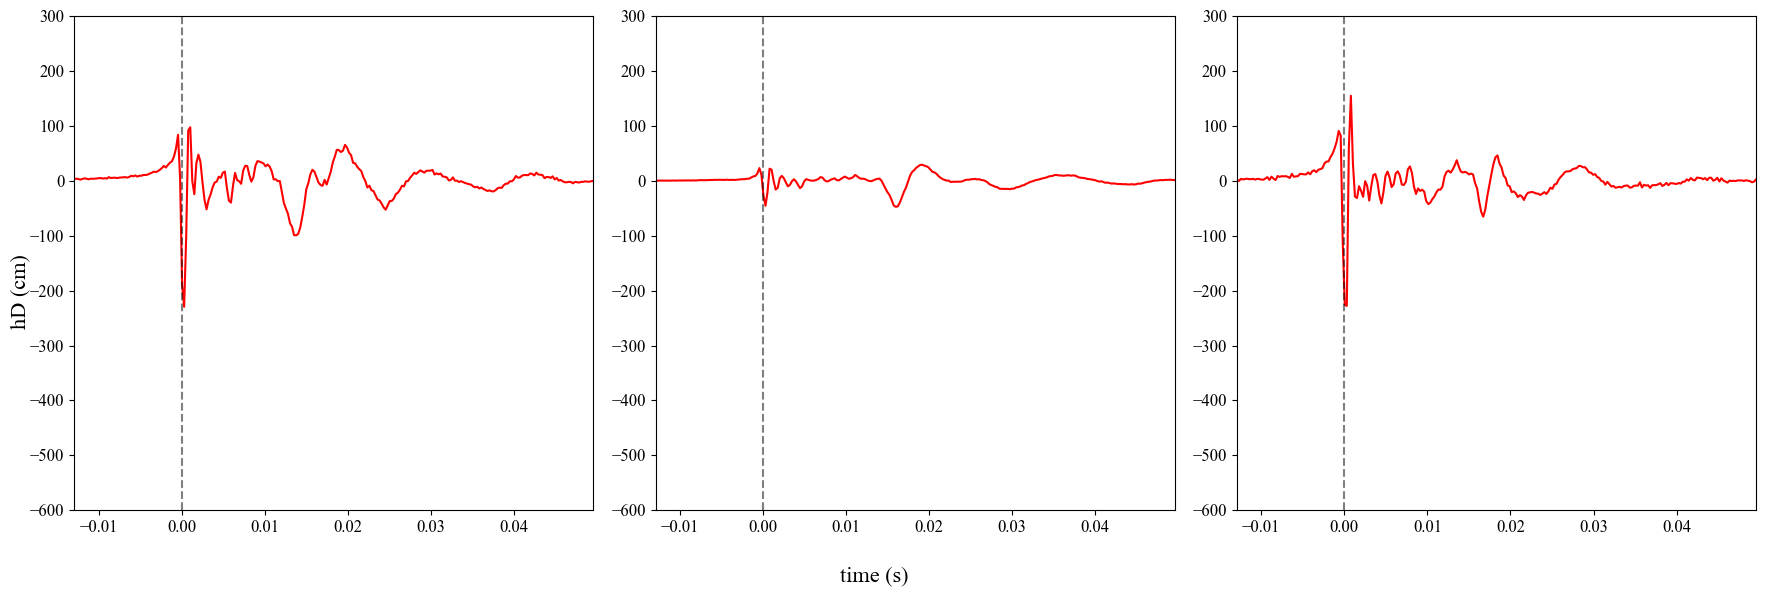

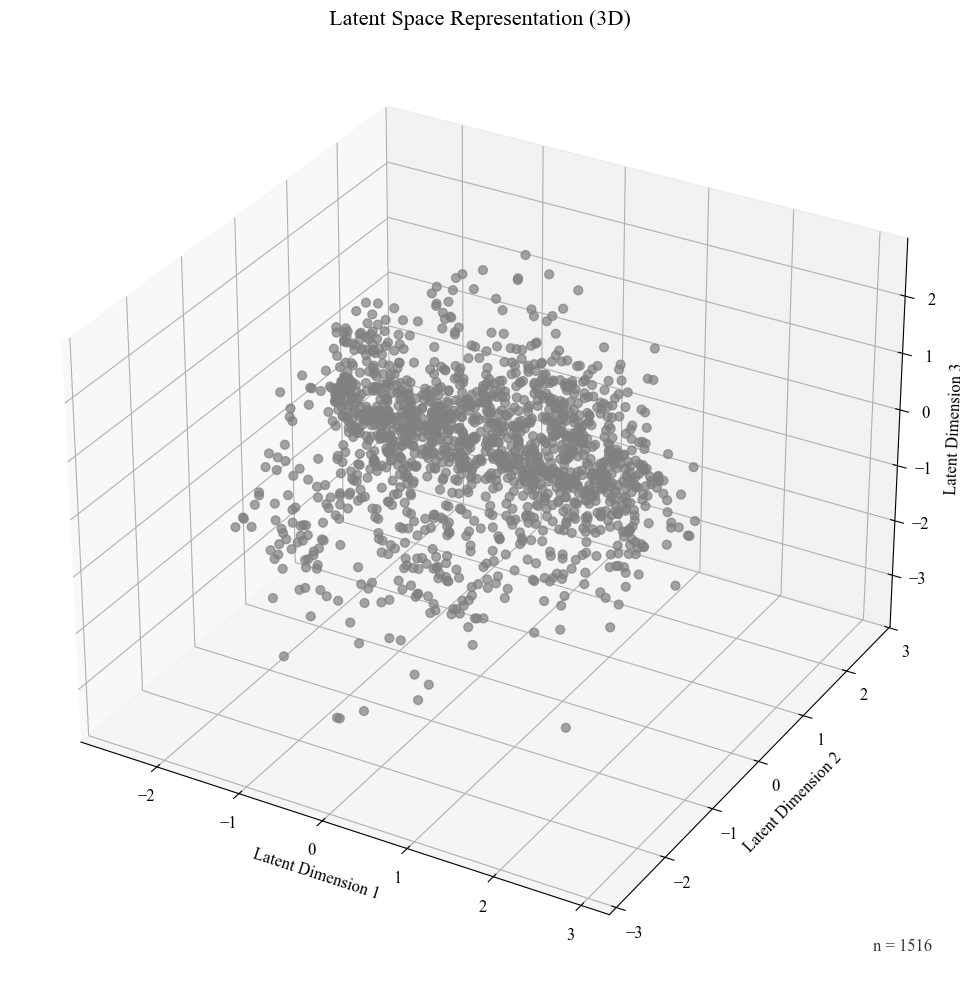

Epochs:  37%|███▋      | 95/256 [03:53<05:53,  2.20s/it]

Generated signals shape: (32, 256)


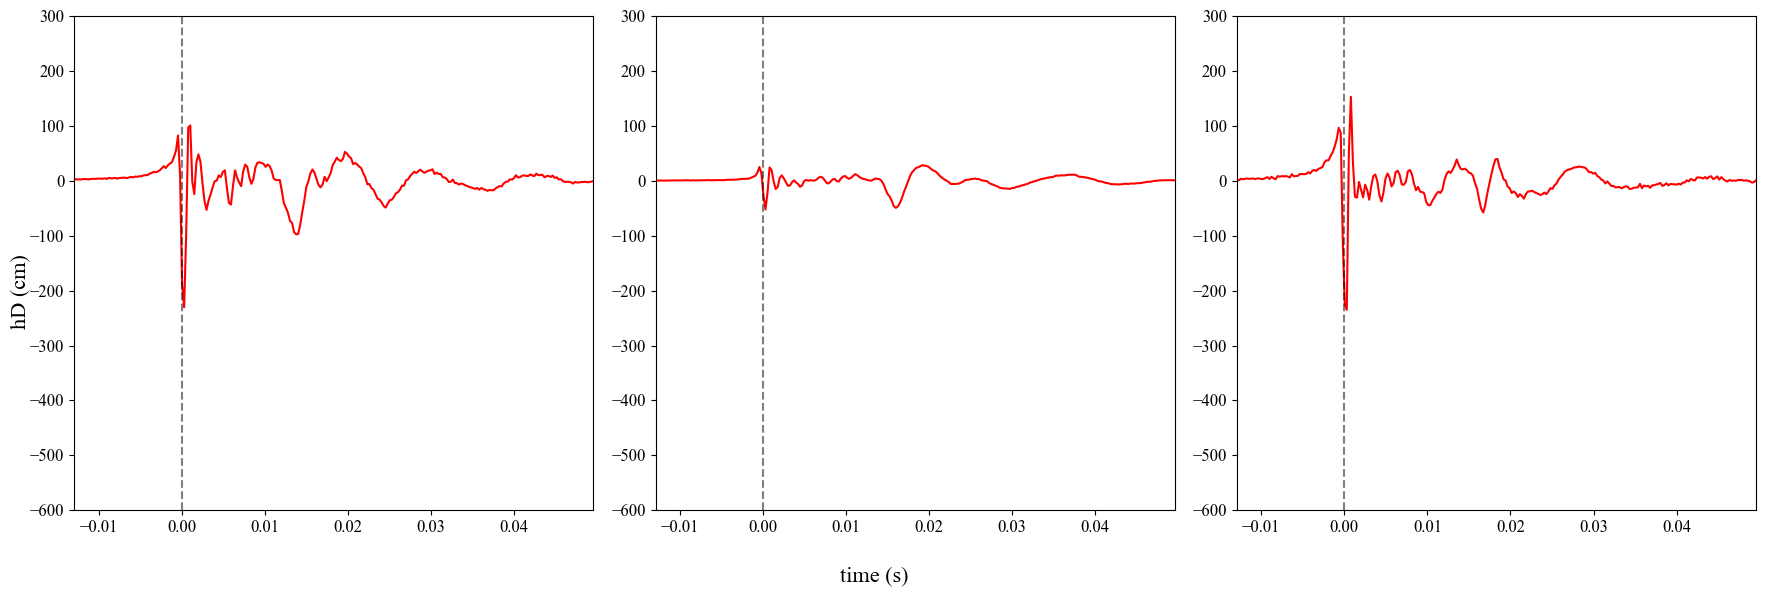

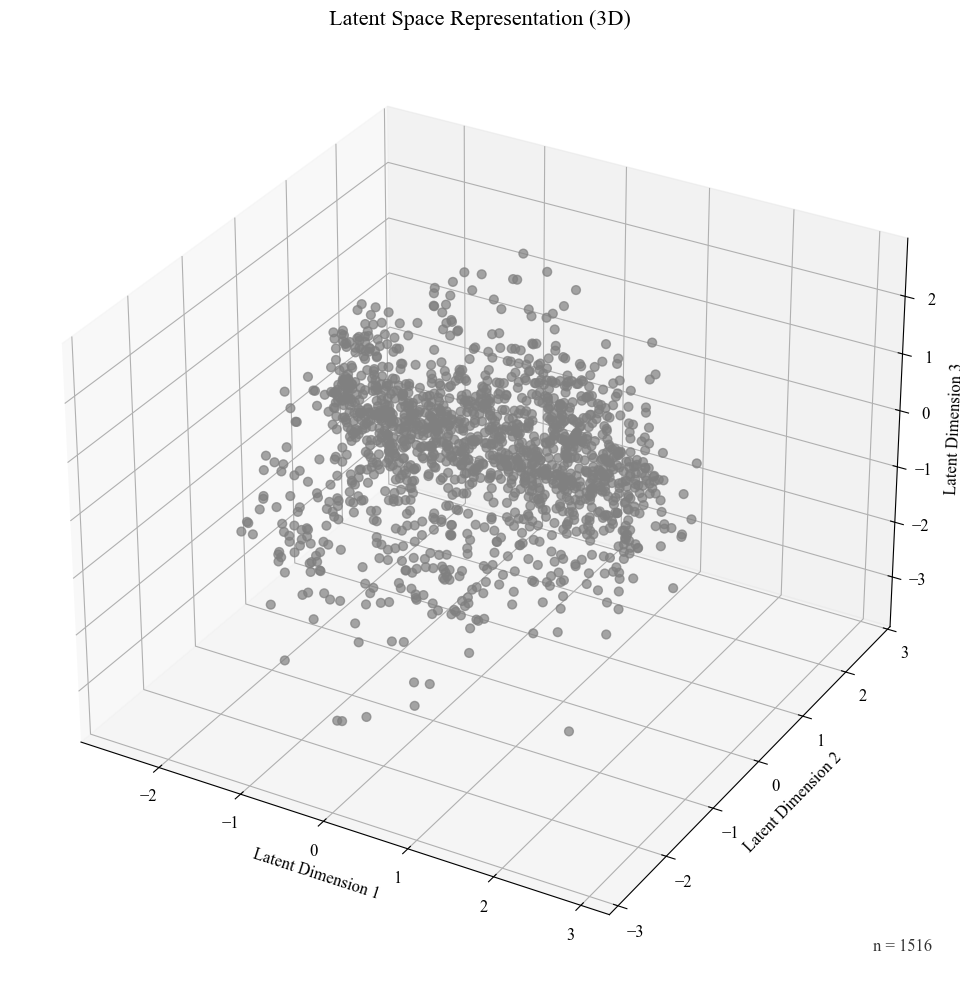

Epochs:  43%|████▎     | 111/256 [04:31<05:23,  2.23s/it]

Generated signals shape: (32, 256)


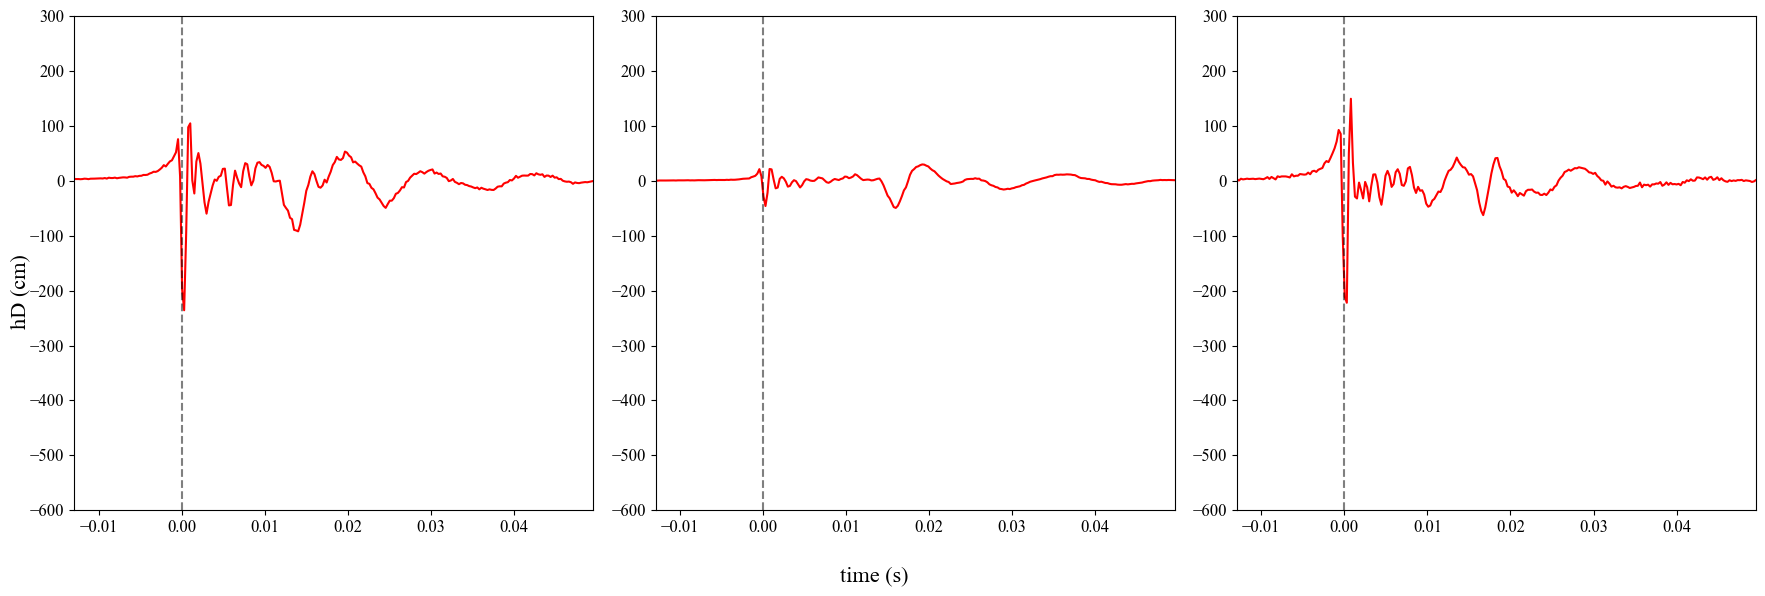

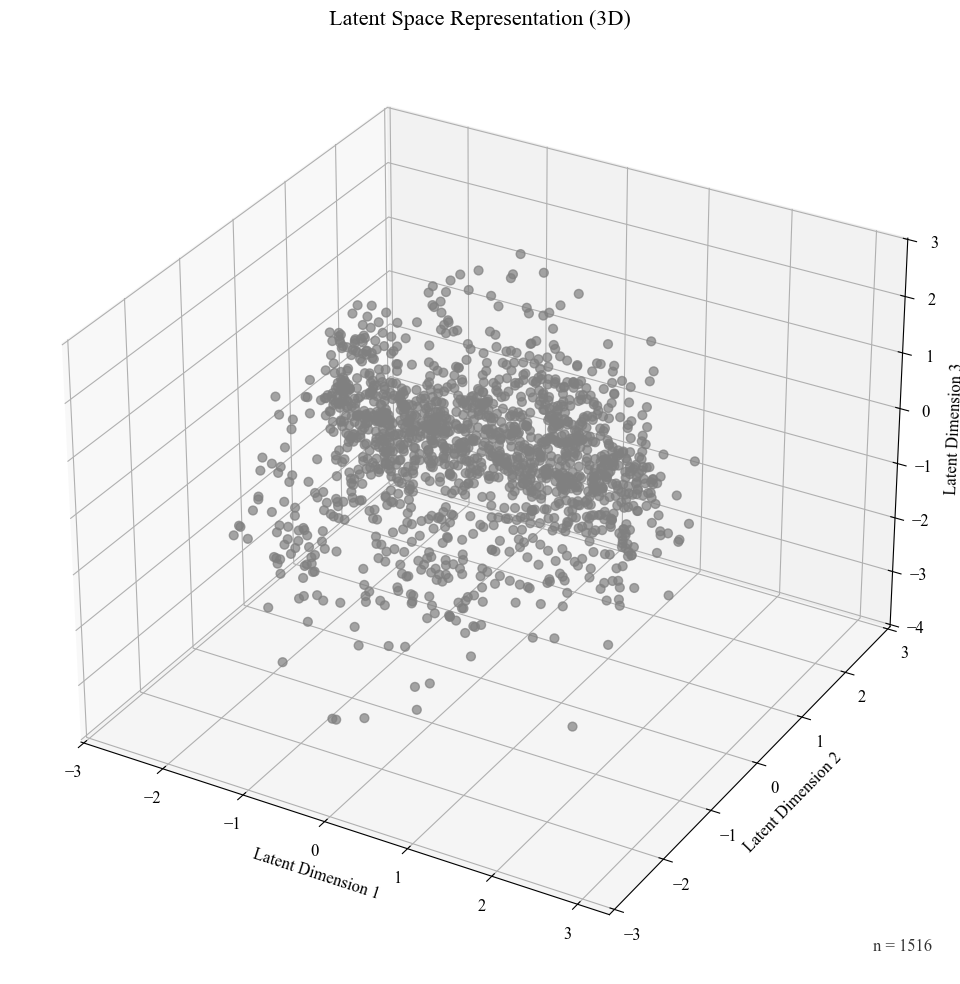

Epochs:  50%|████▉     | 127/256 [05:09<04:52,  2.27s/it]

Generated signals shape: (32, 256)


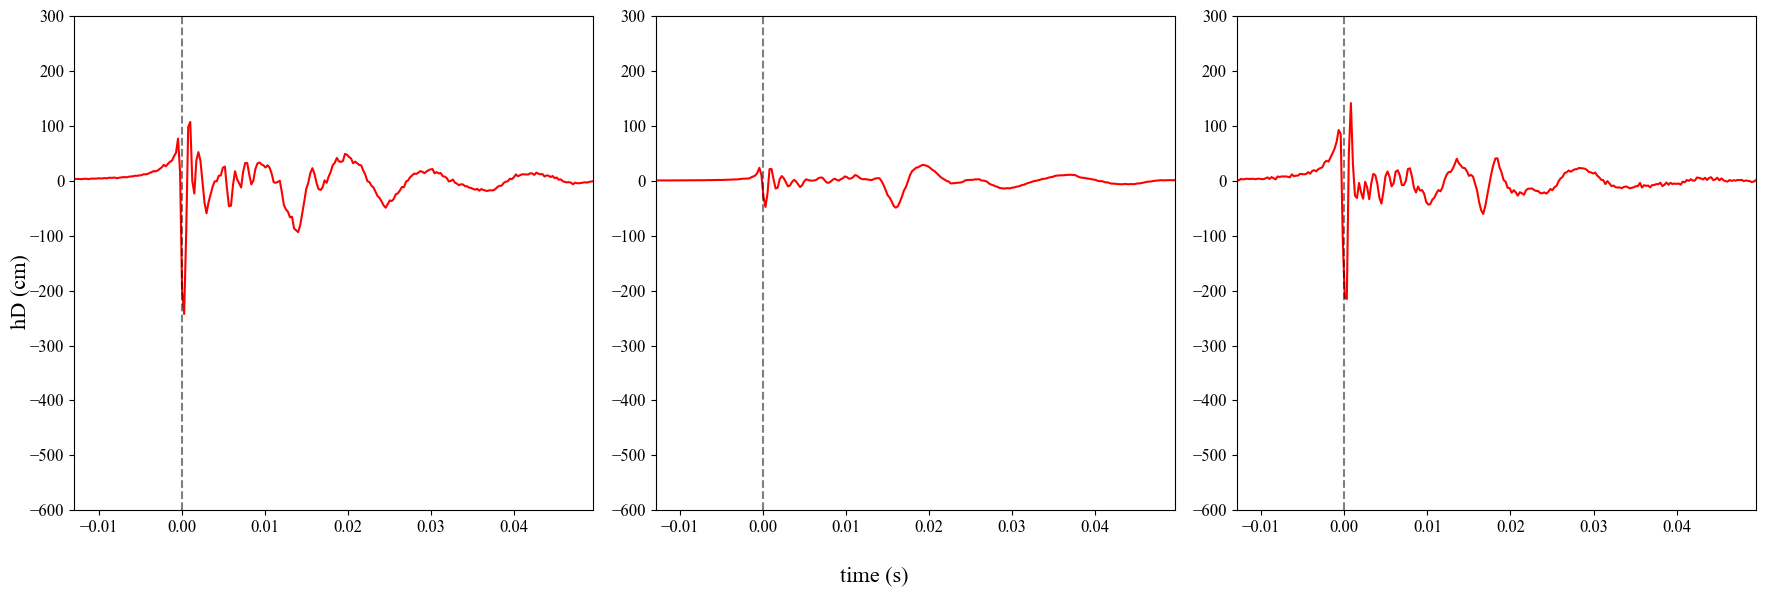

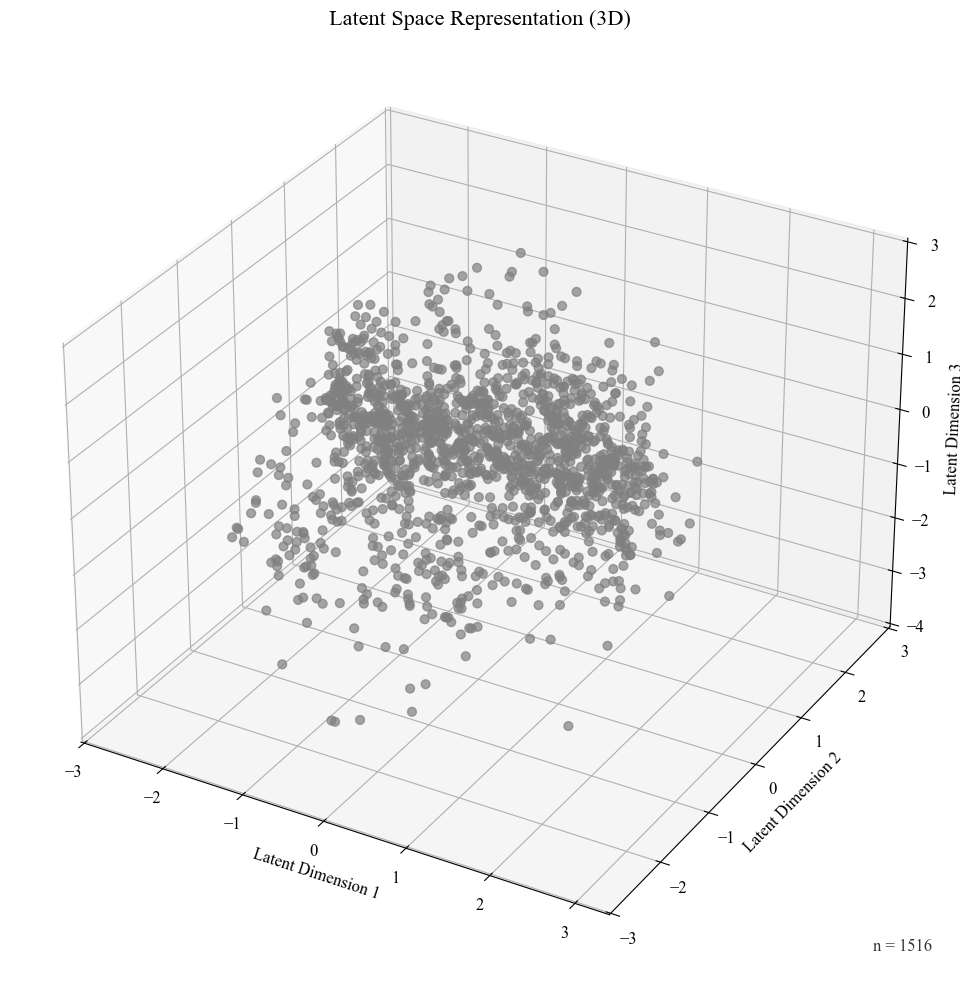

Epochs:  56%|█████▌    | 143/256 [05:48<04:27,  2.36s/it]

Generated signals shape: (32, 256)


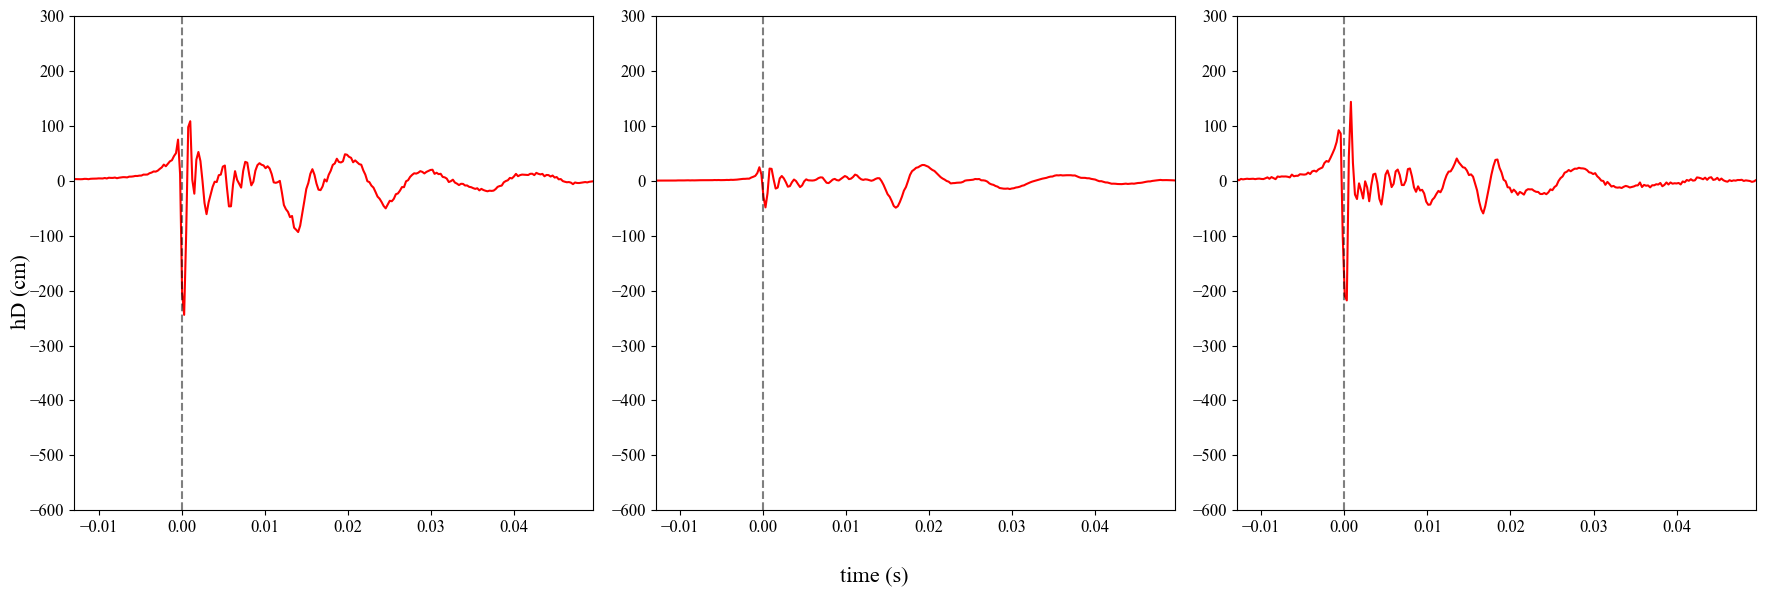

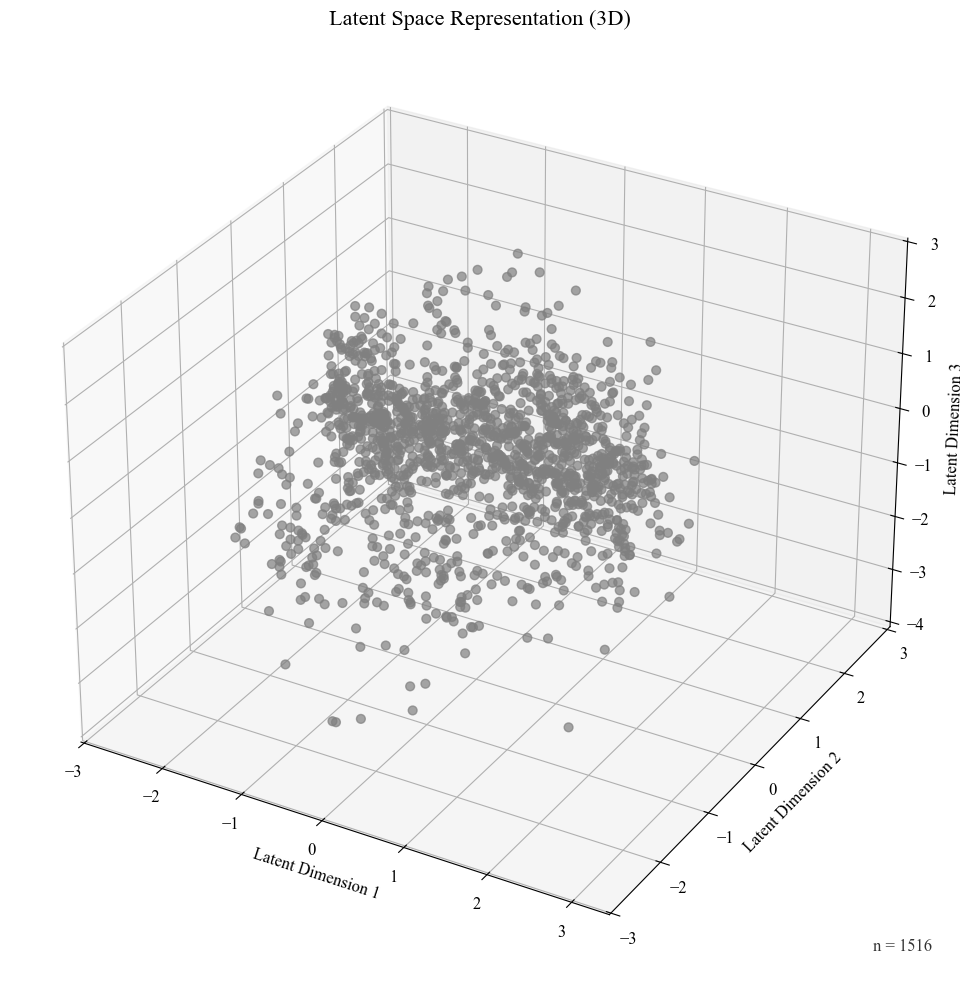

Epochs:  62%|██████▏   | 159/256 [06:28<03:49,  2.36s/it]

Generated signals shape: (32, 256)


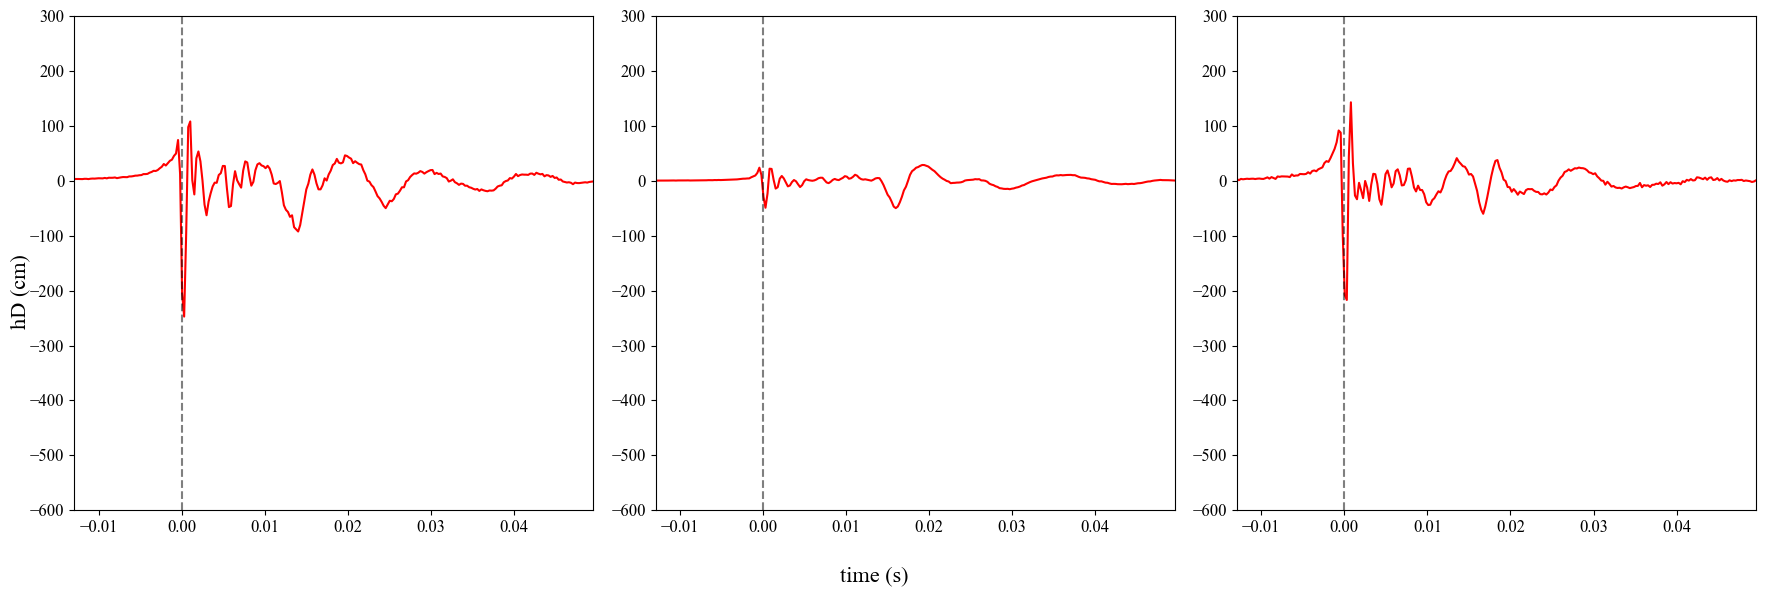

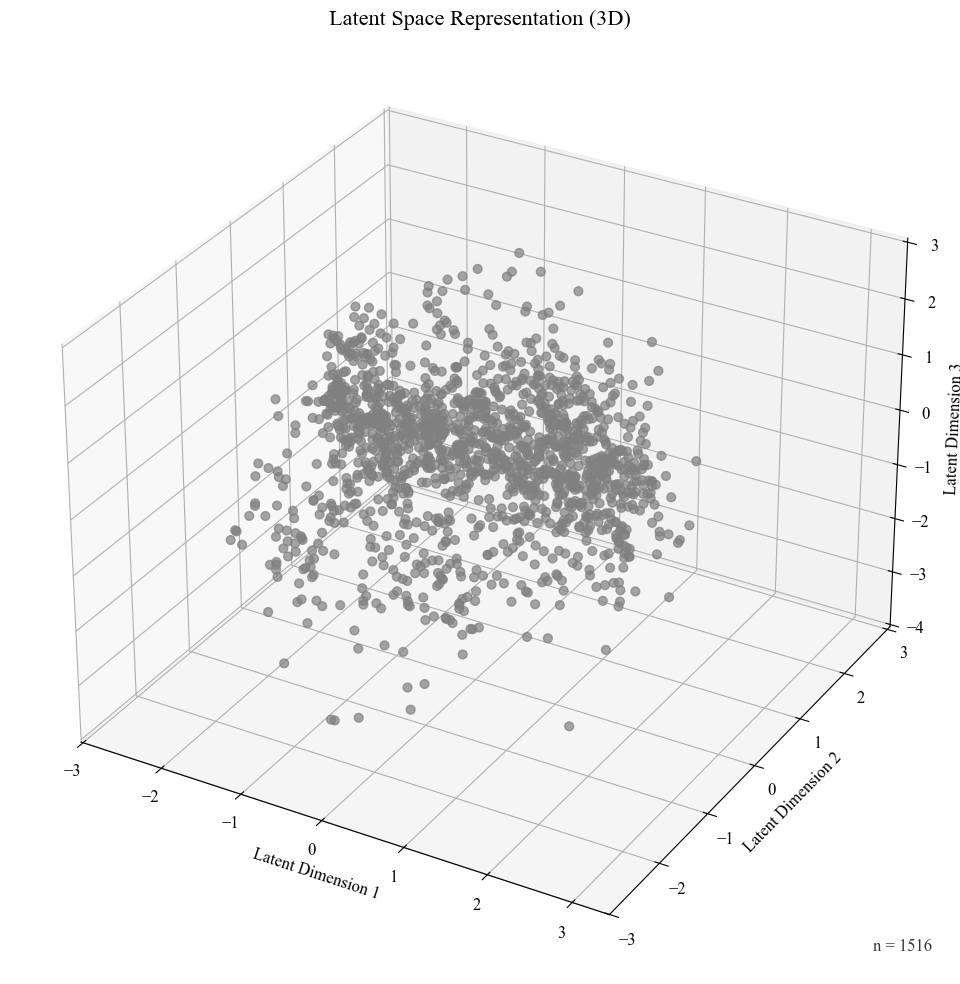

Epochs:  68%|██████▊   | 175/256 [07:09<03:17,  2.44s/it]

Generated signals shape: (32, 256)


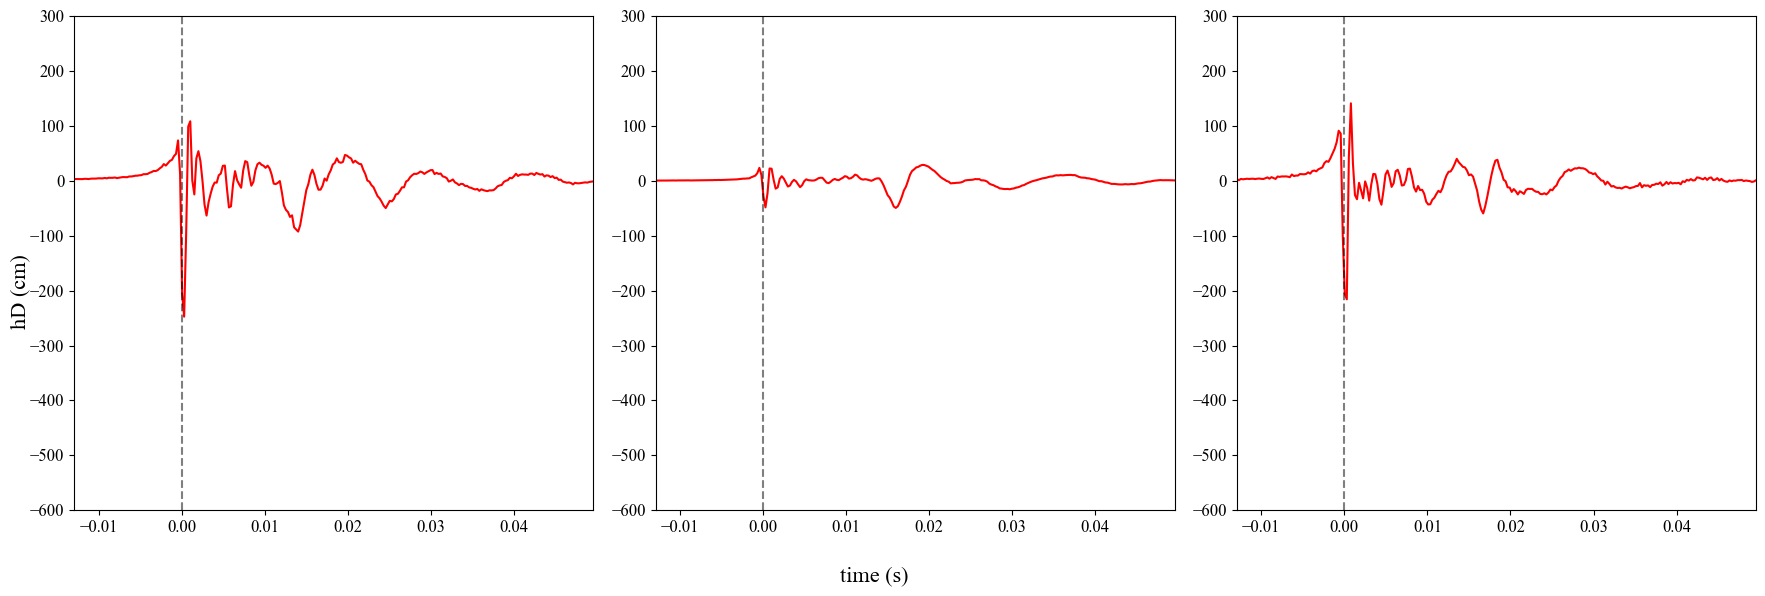

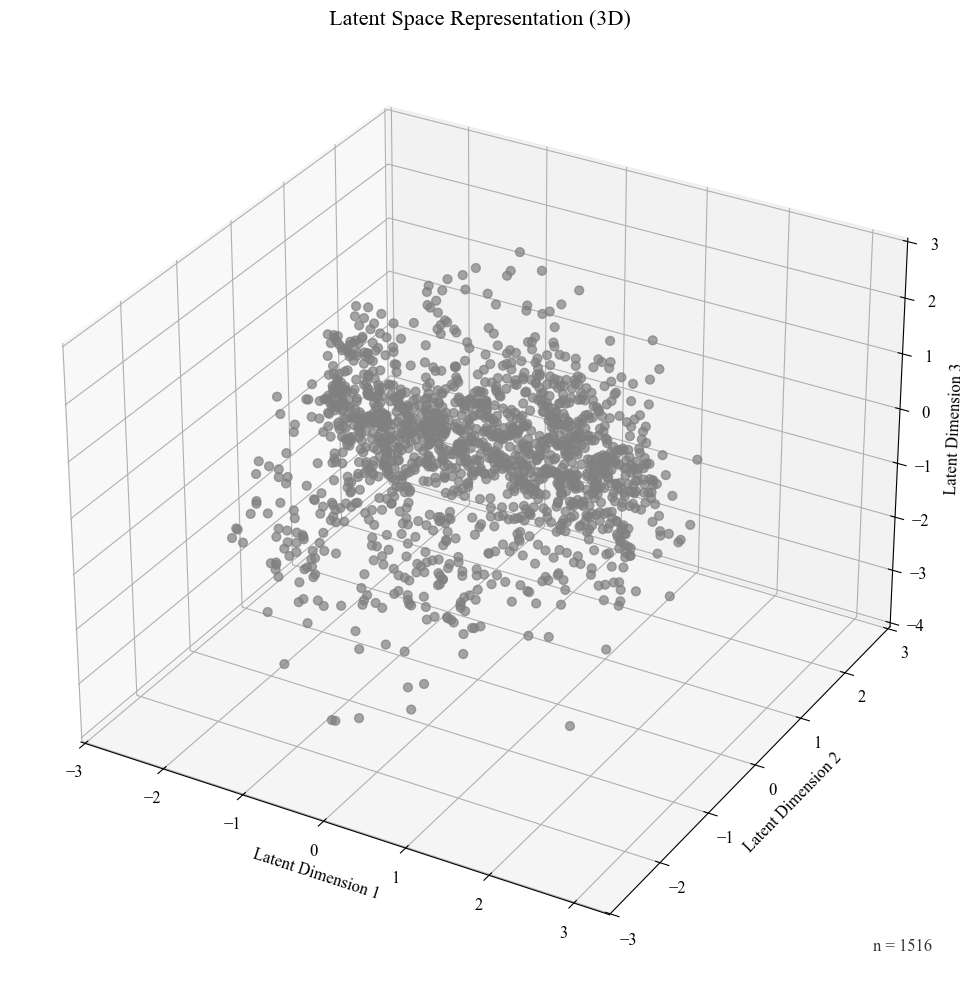

Epochs:  73%|███████▎  | 188/256 [07:42<02:43,  2.40s/it]

In [ ]:
trainer = Trainer(
    toy=toy, 
    start_snr=200,
    end_snr=10,
    noise=True, 
    validation_split=0.1,
    curriculum=True,
    noise_realizations=1  # Increased from 1 to 3 for more data augmentation
)
trainer.train()

### Display Results

In [ ]:
trainer.display_results()

In [ ]:
trainer.plot_generated_signal_distribution(
    background="white",
    font_family="sans-serif",
    font_name="Avenir"
)

In [ ]:
# index = 9

# val_idx = trainer.validation_sampler.indices[index]
# signal, noisy_signal, params = trainer.val_loader.dataset.__getitem__(val_idx)

# trainer.plot_reconstruction_distribution(
#     num_samples=1000,
#     background="white",
#     font_family="sans-serif",
#     font_name="Avenir"
# )

In [ ]:
trainer.save_models()

In [ ]:
trainer.validation_dataset.update_snr(8)
trainer.training_dataset.update_snr(8)
signal, noisy_signal, params = trainer.training_dataset[1]
trainer.plot_corner(signal, noisy_signal, params, index=160)

In [ ]:
# Check 1: Are latent encodings different for different signals?
import torch

num_test_signals = 5
test_indices = [10, 50, 100, 150, 200]

print("=" * 60)
print("DIAGNOSTIC: Checking Latent Encodings")
print("=" * 60)

latents = []
true_params = []

for idx in test_indices:
    signal, noisy_signal, params = trainer.validation_dataset[idx]
    
    # Encode to latent (data is already tensor from dataset)
    with torch.no_grad():
        if isinstance(noisy_signal, np.ndarray):
            noisy_signal_tensor = torch.from_numpy(noisy_signal).unsqueeze(0).to(DEVICE)
        else:
            noisy_signal_tensor = noisy_signal.unsqueeze(0).to(DEVICE)
        
        _, mean, _ = trainer.vae(noisy_signal_tensor)
        mean = mean.view(-1).cpu().numpy()
    
    latents.append(mean)
    
    # Convert params to numpy if needed
    if isinstance(params, torch.Tensor):
        params = params.cpu().numpy()
    true_params.append(params.flatten())
    
    print(f"\nSignal {idx}:")
    print(f"  True params: {params.flatten()}")
    print(f"  Latent (first 5 dims): {mean[:5]}")

# Check variance in latents
latents_array = np.array(latents)
print("\n" + "=" * 60)
print("Latent Statistics Across Signals:")
print(f"  Mean per dimension: {latents_array.mean(axis=0)[:5]}")
print(f"  Std per dimension:  {latents_array.std(axis=0)[:5]}")
print(f"  Are latents all the same? {np.allclose(latents_array[0], latents_array[1:], atol=1e-3)}")

# Check variance in true parameters
true_params_array = np.array(true_params)
print("\n" + "=" * 60)
print("True Parameter Statistics:")
print(f"  Mean: {true_params_array.mean(axis=0)}")
print(f"  Std:  {true_params_array.std(axis=0)}")
print(f"  Min:  {true_params_array.min(axis=0)}")
print(f"  Max:  {true_params_array.max(axis=0)}")
print("=" * 60)

In [ ]:
# Check 2: Does the flow produce different posteriors for different latents?
print("\n" + "=" * 60)
print("DIAGNOSTIC: Checking Flow Posterior Predictions")
print("=" * 60)

num_samples = 1000

for i, idx in enumerate(test_indices[:3]):  # Test 3 signals
    signal, noisy_signal, params = trainer.training_dataset[idx]
    
    # Encode to latent (data is already tensor from dataset)
    with torch.no_grad():
        if isinstance(noisy_signal, np.ndarray):
            noisy_signal_tensor = torch.from_numpy(noisy_signal).unsqueeze(0).to(DEVICE)
        else:
            noisy_signal_tensor = noisy_signal.unsqueeze(0).to(DEVICE)
            
        _, mean, _ = trainer.vae(noisy_signal_tensor)
        z_latent = mean.view(1, -1)
        
        # Sample from flow conditioned on this latent
        samples = trainer.flow.sample(num_samples, context=z_latent).cpu().numpy()
        samples = np.exp(samples) - 1e-8  # Reverse log transform
    
    # Convert params to numpy if needed
    if isinstance(params, torch.Tensor):
        params = params.cpu().numpy()
    
    print(f"\nSignal {idx}:")
    print(f"  True params: {params.flatten()}")
    print(f"  Predicted mean: {samples.mean(axis=0)}")
    print(f"  Predicted std:  {samples.std(axis=0)}")

print("\n" + "=" * 60)
print("If predicted means are all similar, flow is NOT conditioning properly!")
print("=" * 60)

In [ ]:
# Check 3: Detailed analysis of flow samples
print("\n" + "=" * 60)
print("DETAILED DIAGNOSTIC: Flow Sample Analysis")
print("=" * 60)

idx = test_indices[0]  # Test first signal
signal, noisy_signal, params = trainer.validation_dataset[idx]

with torch.no_grad():
    if isinstance(noisy_signal, np.ndarray):
        noisy_signal_tensor = torch.from_numpy(noisy_signal).unsqueeze(0).to(DEVICE)
    else:
        noisy_signal_tensor = noisy_signal.unsqueeze(0).to(DEVICE)
        
    _, mean, _ = trainer.vae(noisy_signal_tensor)
    z_latent = mean.view(1, -1)
    
    # Sample from flow
    samples = trainer.flow.sample(1000, context=z_latent).cpu().numpy()
    
    print(f"\nSignal {idx}:")
    print(f"Samples shape: {samples.shape}")
    print(f"First 5 samples (in log space):")
    for i in range(5):
        print(f"  Sample {i}: {samples[i]}")
    
    print(f"\nAre all samples identical? {np.allclose(samples[0], samples[1:], atol=1e-6)}")
    print(f"Std dev across samples: {samples.std(axis=0)}")
    print(f"Min across samples: {samples.min(axis=0)}")
    print(f"Max across samples: {samples.max(axis=0)}")
    
    # After exp transform
    samples_exp = np.exp(samples) - 1e-8
    print(f"\nAfter exp transform:")
    print(f"Std dev: {samples_exp.std(axis=0)}")
    print(f"Mean: {samples_exp.mean(axis=0)}")

print("\n" + "=" * 60)
print("ISSUE: Flow is deterministic - outputting same value every time!")
print("=" * 60)

### Diagnostic: Check if Flow is Learning Conditional Distribution